## 目的
本ノートブックではVision Transformerを用いた重力波検出のための分類モデルの構築を行う。


In [2]:
#ライブラリインポート
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
#画像前処理のためのtransform定義
transform = transforms.Compose(
    [transforms.CenterCrop(225),
     transforms.Resize(32),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_image_dir = './images/image3/train'
val_image_dir = './images/image2/val'
test_image_dir = './images/image2/test2'



## データセット読み込み

In [4]:
train_set = torchvision.datasets.ImageFolder(root=train_image_dir, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)

validation_set = torchvision.datasets.ImageFolder(root=val_image_dir, transform=transform)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4,
                                         shuffle=False)

test_set = torchvision.datasets.ImageFolder(root=test_image_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False)

classes = ('signal','noise')

## Vision Transformerモデル定義

In [5]:
import torch
import torch.nn as nn

from einops import repeat
from einops.layers.torch import Rearrange


class Patching(nn.Module):
    def __init__(self, patch_size):
 
        super().__init__()
        self.net = Rearrange("b c (h ph) (w pw) -> b (h w) (ph pw c)", ph = patch_size, pw = patch_size)
    
    def forward(self, x):
        x = self.net(x)
        return x


class LinearProjection(nn.Module):
    def __init__(self, patch_dim, dim):
        super().__init__()
        self.net = nn.Linear(patch_dim, dim)

    def forward(self, x):
        x = self.net(x)
        return x


class Embedding(nn.Module):
    def __init__(self, dim, n_patches):
        super().__init__()
        # [class] token
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        # position embedding
        self.pos_embedding = nn.Parameter(torch.randn(1, n_patches + 1, dim))
    
    def forward(self, x):
        # バッチサイズを抽出
        batch_size, _, __ = x.shape

        # [class] トークン付加
        # x.shape : [batch_size, n_patches, patch_dim] -> [batch_size, n_patches + 1, patch_dim]
        cls_tokens = repeat(self.cls_token, "1 1 d -> b 1 d", b = batch_size)
        x = torch.concat([cls_tokens, x], dim = 1)

        # 位置エンコーディング
        x += self.pos_embedding

        return x


class MLP(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        x = self.net(x)
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, dim, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.dim_heads = dim // n_heads

        self.W_q = nn.Linear(dim, dim)
        self.W_k = nn.Linear(dim, dim)
        self.W_v = nn.Linear(dim, dim)

        self.split_into_heads = Rearrange("b n (h d) -> b h n d", h = self.n_heads)

        self.softmax = nn.Softmax(dim = -1)

        self.concat = Rearrange("b h n d -> b n (h d)", h = self.n_heads)

    def forward(self, x):
        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)

        q = self.split_into_heads(q)
        k = self.split_into_heads(k)
        v = self.split_into_heads(v)

        # Logit[i] = Q[i] * tK[i] / sqrt(D) (i = 1, ... , n_heads)
        # AttentionWeight[i] = Softmax(Logit[i]) (i = 1, ... , n_heads)
        logit = torch.matmul(q, k.transpose(-1, -2)) * (self.dim_heads ** -0.5)
        attention_weight = self.softmax(logit)

        # Head[i] = AttentionWeight[i] * V[i] (i = 1, ... , n_heads)
        # Output = concat[Head[1], ... , Head[n_heads]]
        output = torch.matmul(attention_weight, v)
        output = self.concat(output)
        return output


class TransformerEncoder(nn.Module):
    def __init__(self, dim, n_heads, mlp_dim, depth):
        super().__init__()

        # Layers
        self.norm = nn.LayerNorm(dim)
        self.multi_head_attention = MultiHeadAttention(dim = dim, n_heads = n_heads)
        self.mlp = MLP(dim = dim, hidden_dim = mlp_dim)
        self.depth = depth

    def forward(self, x):
        for _ in range(self.depth):
            x = self.multi_head_attention(self.norm(x)) + x
            x = self.mlp(self.norm(x)) + x

        return x


class MLPHead(nn.Module):
    def __init__(self, dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, out_dim)
        )
    
    def forward(self, x):
        x = self.net(x)
        return x


class ViT(nn.Module):
    def __init__(self, image_size, patch_size, n_classes, dim, depth, n_heads, channels = 3, mlp_dim = 256):

        super().__init__()
        
        # Params
        n_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size * patch_size
        self.depth = depth

        # Layers
        self.patching = Patching(patch_size = patch_size)
        self.linear_projection_of_flattened_patches = LinearProjection(patch_dim = patch_dim, dim = dim)
        self.embedding = Embedding(dim = dim, n_patches = n_patches)
        self.transformer_encoder = TransformerEncoder(dim = dim, n_heads = n_heads, mlp_dim = mlp_dim, depth = depth)
        self.mlp_head = MLPHead(dim = dim, out_dim = n_classes)


    def forward(self, img):

        x = img

        # 1. パッチに分割
        # x.shape : [batch_size, channels, image_height, image_width] -> [batch_size, n_patches, channels * (patch_size ** 2)]
        x = self.patching(x)

        # 2. 各パッチをベクトルに変換
        # x.shape : [batch_size, n_patches, channels * (patch_size ** 2)] -> [batch_size, n_patches, dim]
        x = self.linear_projection_of_flattened_patches(x)

        # 3. [class] トークン付加 + 位置エンコーディング 
        # x.shape : [batch_size, n_patches, dim] -> [batch_size, n_patches + 1, dim]
        x = self.embedding(x)

        # 4. Transformer Encoder
        # x.shape : No Change
        x = self.transformer_encoder(x)

        # 5. 出力の0番目のベクトルを MLP Head で処理
        # x.shape : [batch_size, n_patches + 1, dim] -> [batch_size, dim] -> [batch_size, n_classes]
        x = x[:, 0]
        x = self.mlp_head(x)

        return x

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
net = ViT(
    image_size=32,
    patch_size=4,
    n_classes=2,
    dim=256,
    depth=3,
    n_heads=4,
    mlp_dim = 256
).to(device)

In [8]:
import torch.optim as optim
import torch.nn as nn

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

## 学習・検証

In [10]:
epochs = 10
accuracy=[]
losses=[]
val_accuracy=[]
val_losses=[]
for epoch in range(0, epochs):
    epoch_train_loss = 0
    epoch_train_acc = 0
    epoch_val_loss = 0
    epoch_val_acc = 0

    net.train()
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()/len(train_loader)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        epoch_train_acc += acc/len(train_loader)

        del inputs
        del outputs
        del loss
    accuracy.append(epoch_train_acc)
    losses.append(epoch_train_loss)

    net.eval()
    with torch.no_grad():
        for data in validation_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()/len(validation_loader)
            val_acc = (outputs.argmax(dim=1) == labels).float().mean()
            epoch_val_acc += val_acc/len(validation_loader)
        val_accuracy.append(epoch_val_acc)
        val_losses.append(epoch_val_loss)

    print(f'Epoch {epoch+1} : train acc. {epoch_train_acc:.2f} train loss {epoch_train_loss:.2f}')
    print(f'Epoch {epoch+1} : val acc. {epoch_val_acc:.2f} val loss {epoch_val_loss:.2f}')

Epoch 1 : train acc. 0.71 train loss 0.60
Epoch 1 : val acc. 0.83 val loss 0.41
Epoch 2 : train acc. 0.91 train loss 0.23
Epoch 2 : val acc. 0.84 val loss 0.61
Epoch 3 : train acc. 0.96 train loss 0.12
Epoch 3 : val acc. 0.88 val loss 0.50
Epoch 4 : train acc. 0.98 train loss 0.06
Epoch 4 : val acc. 0.95 val loss 0.14
Epoch 5 : train acc. 0.99 train loss 0.03
Epoch 5 : val acc. 0.93 val loss 0.44
Epoch 6 : train acc. 0.99 train loss 0.03
Epoch 6 : val acc. 0.95 val loss 0.21
Epoch 7 : train acc. 0.99 train loss 0.02
Epoch 7 : val acc. 0.97 val loss 0.14
Epoch 8 : train acc. 1.00 train loss 0.01
Epoch 8 : val acc. 0.95 val loss 0.26
Epoch 9 : train acc. 1.00 train loss 0.01
Epoch 9 : val acc. 0.95 val loss 0.33
Epoch 10 : train acc. 1.00 train loss 0.00
Epoch 10 : val acc. 0.96 val loss 0.28


## 学習・検証結果確認

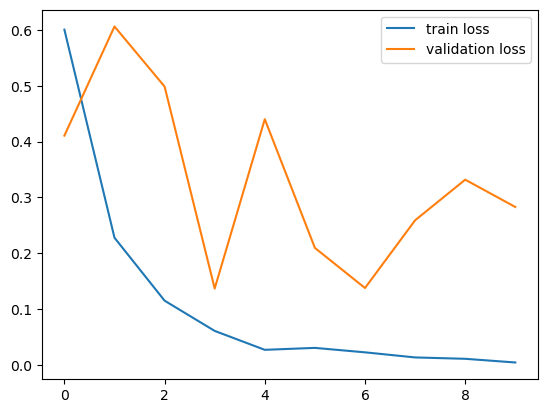

In [14]:
import matplotlib.pyplot as plt
plt.plot(losses, label='train loss')
plt.plot(val_losses, label='validation loss')
#plt.ylim(-0.01,0.2)
plt.legend()

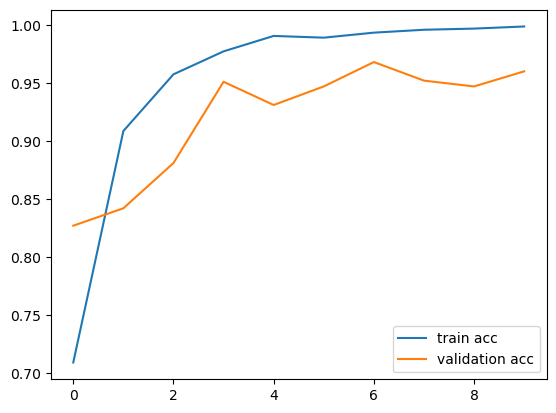

In [15]:
plt.plot(accuracy, label='train acc')
plt.plot(val_accuracy, label='validation acc')
# plt.ylim(0.96,1.005)
plt.legend()

## テスト

In [19]:
import time
epoch_test_loss = 0
epoch_test_acc = 0
start=time.time()
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        epoch_test_loss += loss.item()/len(test_loader)
        test_acc = (outputs.argmax(dim=1) == labels).float().mean()
        epoch_test_acc += test_acc/len(test_loader)

        
end = time.time()
print(end-start)
print(f'Epoch {epoch+1} : test acc. {epoch_test_acc:.2f} test loss {epoch_test_loss:.2f}')

7.821200847625732
Epoch 10 : test acc. 1.00 test loss 0.00
